<font color=red>注：此处是文档第33页</font>

## PyTorch图像分类器

你已经了解了如何定义神经网络，计算损失值和网络里权重的更新。

现在你也许会想应该怎么处理数据？

通常来说，当你处理图像，文本，语音或者视频数据时，你可以使用标准 python 包将数据加载成numpy 数组格式，然后将这个数组转换成 torch.*Tensor
- 对于图像，可以用 Pillow，OpenCV
- 对于语音，可以用 scipy，librosa
- 对于文本，可以直接用 Python 或 Cython 基础数据加载模块，或者用 NLTK 和 SpaCy

特别是对于视觉，我们已经创建了一个叫做 totchvision 的包，该包含有支持加载类似Imagenet，CIFAR10，MNIST 等公共数据集的数据加载模块torchvision.datasets 和支持加载图像数据数据转换模块 torch.utils.data.DataLoader。

这提供了极大的便利，并且避免了编写“样板代码”。

对于本教程，我们将使用CIFAR10数据集，它包含十个类别：‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’,‘horse’, ‘ship’, ‘truck’。CIFAR-10 中的图像尺寸为3*32*32，也就是RGB的3层颜色通道，每层通道内的尺寸为32*32。

### 训练一个图像分类器

我们将按次序的做如下几步：

1. 使用torchvision加载并且归一化CIFAR10的训练和测试数据集
2. 定义一个卷积神经网络
3. 定义一个损失函数
4. 在训练样本数据上训练网络
5. 在测试样本数据上测试网络

加载并归一化 CIFAR10 使用 torchvision ,用它来加载 CIFAR10 数据非常简单。

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 数据集的输出是范围在[0,1]之间的 PILImage，我们将他们转换成归一化范围为[-1,1]之间的张量 Tensors。

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='../../data', train=True,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


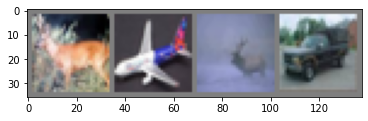

 deer plane  deer truck


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(" ".join("%5s" % classes[labels[j]] for j in range(4)))

定义一个卷积神经网络 在这之前先 从神经网络章节 复制神经网络，并修改它为3通道的图片(在此之前它被定义为1通道）

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channe3, 6 output channels, 5x5 square convolution(3输入图像通道，6个输出通道，5x5平方卷积)
        # kernel
        self.cov1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.cov2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = W*x + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.cov1(x)))
        x = self.pool(F.relu(self.cov2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (cov1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cov2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
